# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

In [1]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

import warnings
warnings.filterwarnings('ignore')

## Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)
        
# loading the match data
matches={}
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the competitions data
competitions={}
with open('./data/competitions.json') as json_data:
    competitions = json.load(json_data)

# loading the teams data
teams={}
with open('./data/teams.json') as json_data:
    teams = json.load(json_data)

### JSON to DataFrame

In [3]:
teams_df = pd.DataFrame(teams)
players_df = pd.DataFrame(players)
competitions_df = pd.DataFrame(competitions)
matches_df = {
    'Italy': pd.DataFrame(matches['Italy']),
    'England': pd.DataFrame(matches['England']),
    'Germany': pd.DataFrame(matches['Germany']),
    'France': pd.DataFrame(matches['France']),
    'Spain': pd.DataFrame(matches['Spain']),
    'European_Championship': pd.DataFrame(matches['European_Championship']),
    'World_Cup': pd.DataFrame(matches['World_Cup'])
}
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

### Some data preparation

In [4]:
def extract_role(role):
    return role.get('code2')

In [5]:
players_df['role'] = players_df['role'].apply(extract_role)
players_df.drop(columns={'passportArea','weight','height','foot','birthArea','birthDate','middleName','firstName','lastName'},inplace=True)

In [6]:
players_df.head()

,currentTeamId,role,wyId,shortName,currentNationalTeamId
0,4502,GK,32777,H. Tekin,4687
1,3775,DF,393228,M. Sarr,4423
2,3772,GK,393230,O. Mandanda,null
3,683,MD,32793,A. N'Diaye,19314
4,2975,DF,393247,I. Konat\u00e9,null


In [7]:
teams_df['area'] = teams_df['area'].apply(lambda x: x.get('name'))

In [8]:
teams_df.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,England,club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,Spain,club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,Spain,club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,Spain,club
4,Valencia,Levante,695,Levante UD,Spain,club


## Italian first division analysis

In [9]:
italian_teams_df = teams_df[(teams_df['area'] == 'Italy') & (teams_df['type'] == 'club')]

Removing the events that cause the game interruption

In [10]:
italian_events_df = events_df['Italy'][events_df['Italy']['playerId'] != 0]

In [11]:
italian_matches_df = matches_df['Italy']

I only need the first component of a pass, cross... So I can remove the second component

In [12]:
italian_events_df['positions'] = italian_events_df['positions'].apply(lambda x: x[0] if x else None)

Furthermore, I am decomposing the position in two columns: 'x' and 'y'

In [13]:
italian_events_df['x'] = italian_events_df['positions'].apply(lambda x: x.get('x'))
italian_events_df['y'] = italian_events_df['positions'].apply(lambda x: x.get('y'))
italian_events_df.drop(columns={'positions'},inplace=True)

I am also going to change the name of the columns wyId in both players_df and italian_matches_df, in order to make a join among italian_events_df and the other two DataFrames just mentioned

In [14]:
players_df.rename(columns={'wyId':'playerId'}, inplace=True)
italian_matches_df.rename(columns={'wyId':'matchId'}, inplace=True)

Now I merge the three DataFrames

In [15]:
events_players_matches_join_df = pd.merge(italian_events_df, players_df, on='playerId', how='left')

In [16]:
events_players_matches_join_df = pd.merge(events_players_matches_join_df, italian_matches_df, on='matchId', how='left')

In [17]:
events_players_matches_join_df.drop(columns={'status','competitionId','seasonId','date','referees','duration',
                                             'venue', 'dateutc', 'shortName', 'roundId', 'teamsData', 'label',
                                             'currentTeamId', 'currentNationalTeamId'},inplace=True)

In [18]:
events_players_matches_join_df.head()

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,role,gameweek,winner
0,8,Simple pass,[{'id': 1801}],8327,2575959,Pass,3158,1H,2.530536,85,180423957,49,52,FW,1,3158
1,8,Simple pass,[{'id': 1801}],20438,2575959,Pass,3158,1H,3.768418,85,180423958,43,44,MD,1,3158
2,7,Touch,[],8306,2575959,Others on the ball,3158,1H,4.868265,72,180423959,36,17,DF,1,3158
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,2575959,Duel,3158,1H,8.114676,11,180423960,78,56,DF,1,3158
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,2575959,Duel,3158,1H,8.647892,11,180423961,64,15,DF,1,3158


Now we analyze the distance made by players during a match

In [19]:
# Sort the dataframe by playerId, matchId, matchPeriod, gameweek, and eventSec
events_players_matches_join_df.sort_values(by=['matchId', 'playerId', 'matchPeriod', 'eventSec'], inplace=True)

# Compute the distance between consecutive points
events_players_matches_join_df['distance'] = np.sqrt(((events_players_matches_join_df.groupby(['matchId', 'playerId', 'matchPeriod'])['x'].diff()**2) + (events_players_matches_join_df.groupby(['playerId', 'matchId', 'matchPeriod', 'gameweek'])['y'].diff()**2)))

# Fill NaN values with 0
events_players_matches_join_df['distance'].fillna(0, inplace=True)

In [20]:
italian_events_df.shape

(600585, 13)

In [21]:
events_players_matches_join_df

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,role,gameweek,winner,distance
62,1,Ground loose ball duel,"[{'id': 701}, {'id': 1802}]",114,2575959,Duel,3158,1H,190.033380,13,180424030,32,66,MD,1,3158,0.000000
69,8,Simple pass,[{'id': 1801}],114,2575959,Pass,3158,1H,201.317410,85,180424039,37,76,MD,1,3158,11.180340
73,8,Simple pass,[{'id': 1801}],114,2575959,Pass,3158,1H,210.057782,85,180424047,30,79,MD,1,3158,7.615773
82,8,Simple pass,[{'id': 1801}],114,2575959,Pass,3158,1H,240.645201,85,180424066,64,37,MD,1,3158,54.037024
85,8,High pass,"[{'id': 302}, {'id': 901}, {'id': 1801}]",114,2575959,Pass,3158,1H,247.586484,83,180424076,71,75,MD,1,3158,38.639358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600518,8,Simple pass,[{'id': 1801}],413041,2576338,Pass,3193,2H,2658.089531,85,253567073,54,26,DF,38,3185,11.704700
600531,3,Throw in,[{'id': 1801}],413041,2576338,Free Kick,3193,2H,2690.255785,36,253567089,19,0,DF,38,3185,43.600459
600568,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",413041,2576338,Duel,3193,2H,2798.923456,11,253567142,33,60,DF,38,3185,61.611687
600570,8,Simple pass,[{'id': 1801}],413041,2576338,Pass,3193,2H,2801.914483,85,253567136,25,57,DF,38,3185,8.544004


In [22]:
players_distances = events_players_matches_join_df.groupby(['playerId', 'matchId'])['distance'].sum()

In [23]:
players_distances_filtered = players_distances[players_distances != 0]

In [24]:
players_distances_rounded = round(players_distances_filtered, -2)

In [25]:
players_distances_df = pd.DataFrame(players_distances_rounded)

In [26]:
players_distances_df.head()

distance
playerId matchId          
45       2576030     900.0
         2576109    1600.0
         2576126    1700.0
         2576129    1700.0
         2576154     200.0

In [27]:
# Count the occurrences of each unique distance value
distance_counts = players_distances_df['distance'].value_counts().reset_index()

# Sort the DataFrame by distance
distance_counts = distance_counts.sort_values(by='distance')

In [28]:
distance_counts['distance'] = distance_counts['distance'].astype(int)

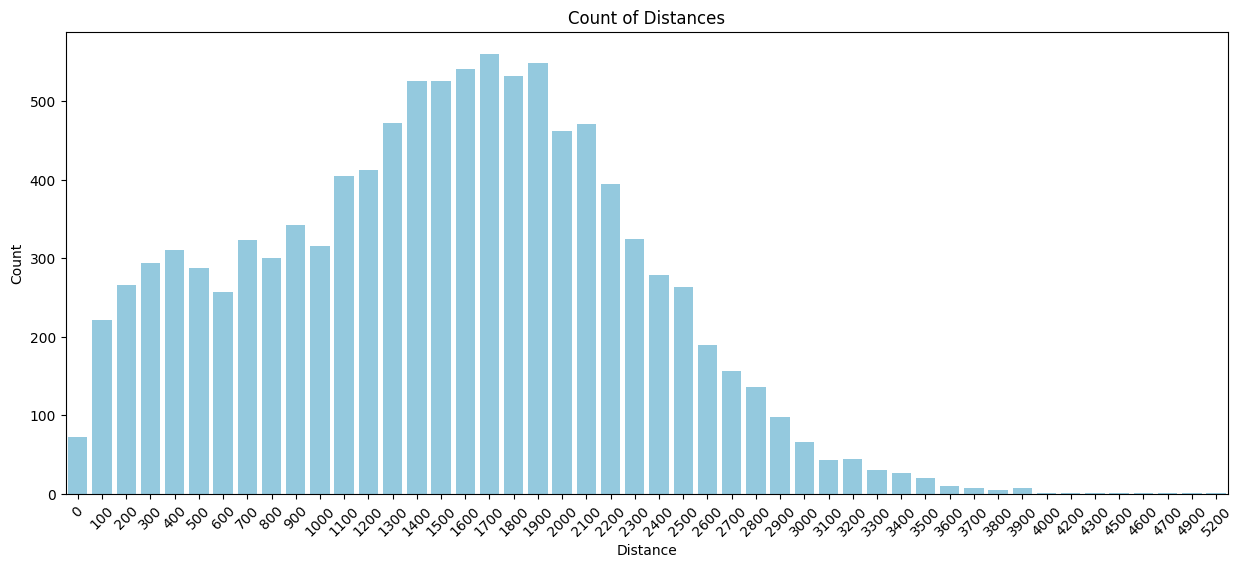

In [29]:
plt.figure(figsize=(15, 6))
sns.barplot(data=distance_counts, x='distance', y='count', color='skyblue')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Count of Distances')
plt.xticks(rotation=45)
plt.show()

In [30]:
players_role_distances_df = players_distances_df.merge(players_df, on='playerId', how='left').drop(columns={'shortName', 'currentNationalTeamId', 'currentTeamId'})
players_role_distances_df

,playerId,distance,role
0,45,900.0,DF
1,45,1600.0,DF
2,45,1700.0,DF
3,45,1700.0,DF
4,45,200.0,DF
...,...,...,...
10546,523089,2000.0,MD
10547,523089,1600.0,MD
10548,523089,800.0,MD
10549,523089,1400.0,MD


In [36]:
# Count the occurrences of each unique distance value
distance_counts_by_role = players_role_distances_df[['distance', 'role']].value_counts().reset_index()

# Sort the DataFrame by distance
distance_counts_by_role = distance_counts_by_role.sort_values(by='distance')

distance_counts_by_role['distance'] = distance_counts_by_role['distance'].astype(int)

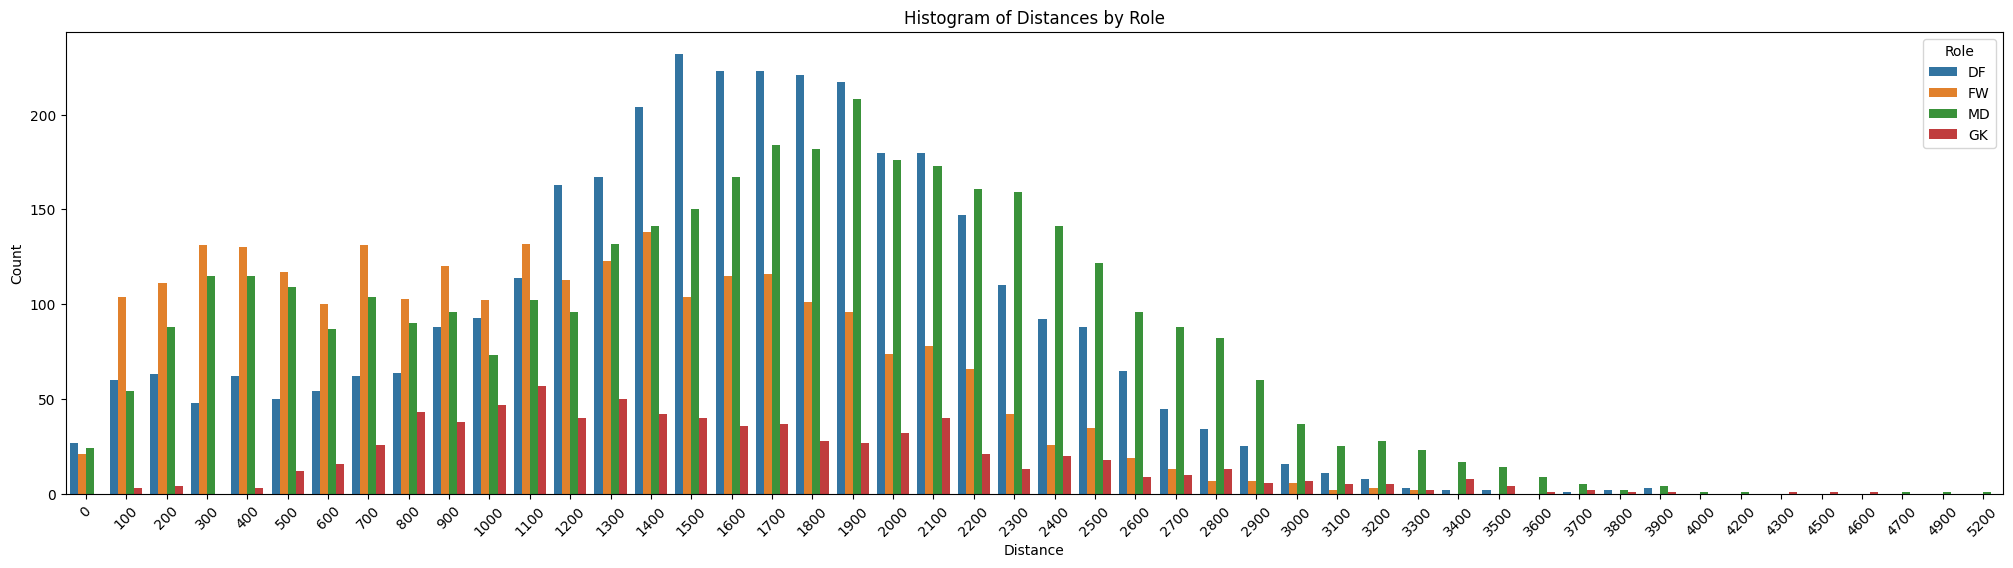

In [39]:
plt.figure(figsize=(25, 6))
sns.barplot(data=distance_counts_by_role, x='distance', y='count', hue='role')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Histogram of Distances by Role')
plt.legend(title='Role')
plt.xticks(rotation=45)
plt.show()

## English first division analysis

In [40]:
english_teams_df = teams_df[(teams_df['area'] == 'England') & (teams_df['type'] == 'club')]

Removing the events that cause the game interruption

In [41]:
english_events_df = events_df['England'][events_df['England']['playerId'] != 0]

In [42]:
english_matches_df = matches_df['England']

I only need the first component of a pass, cross... So I can remove the second component

In [43]:
english_events_df['positions'] = english_events_df['positions'].apply(lambda x: x[0] if x else None)

Furthermore, I am decomposing the position in two columns: 'x' and 'y'

In [44]:
english_events_df['x'] = english_events_df['positions'].apply(lambda x: x.get('x'))
english_events_df['y'] = english_events_df['positions'].apply(lambda x: x.get('y'))
english_events_df.drop(columns={'positions'},inplace=True)

I am also going to change the name of the columns wyId in both players_df and italian_matches_df, in order to make a join among italian_events_df and the other two DataFrames just mentioned

In [45]:
english_matches_df.rename(columns={'wyId':'matchId'}, inplace=True)

Now I merge the three DataFrames

In [46]:
events_players_matches_join_df = pd.merge(english_events_df, players_df, on='playerId', how='left')

In [47]:
events_players_matches_join_df = pd.merge(events_players_matches_join_df, english_matches_df, on='matchId', how='left')

In [48]:
events_players_matches_join_df.drop(columns={'status','competitionId','seasonId','date','referees','duration',
                                             'venue', 'dateutc', 'shortName', 'roundId', 'teamsData', 'label',
                                             'currentTeamId', 'currentNationalTeamId'},inplace=True)

In [49]:
events_players_matches_join_df.head()

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,role,gameweek,winner
0,8,Simple pass,[{'id': 1801}],25413,2499719,Pass,1609,1H,2.758649,85,177959171,49,49,FW,1,1609
1,8,High pass,[{'id': 1801}],370224,2499719,Pass,1609,1H,4.946850,83,177959172,31,78,DF,1,1609
2,8,Head pass,[{'id': 1801}],3319,2499719,Pass,1609,1H,6.542188,82,177959173,51,75,MD,1,1609
3,8,Head pass,[{'id': 1801}],120339,2499719,Pass,1609,1H,8.143395,82,177959174,35,71,MD,1,1609
4,8,Simple pass,[{'id': 1801}],167145,2499719,Pass,1609,1H,10.302366,85,177959175,41,95,DF,1,1609


Now we analyze the distance made by players during a match

In [50]:
# Sort the dataframe by playerId, matchId, matchPeriod, gameweek, and eventSec
events_players_matches_join_df.sort_values(by=['matchId', 'playerId', 'matchPeriod', 'eventSec'], inplace=True)

# Compute the distance between consecutive points
events_players_matches_join_df['distance'] = np.sqrt(((events_players_matches_join_df.groupby(['matchId', 'playerId', 'matchPeriod'])['x'].diff()**2) + (events_players_matches_join_df.groupby(['playerId', 'matchId', 'matchPeriod', 'gameweek'])['y'].diff()**2)))

# Fill NaN values with 0
events_players_matches_join_df['distance'].fillna(0, inplace=True)

In [52]:
english_events_df.shape

(595119, 13)

In [53]:
events_players_matches_join_df

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,role,gameweek,winner,distance
2,8,Head pass,[{'id': 1801}],3319,2499719,Pass,1609,1H,6.542188,82,177959173,51,75,MD,1,1609,0.000000
5,8,Simple pass,[{'id': 1802}],3319,2499719,Pass,1609,1H,12.548934,85,177959177,72,88,MD,1,1609,24.698178
45,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",3319,2499719,Duel,1609,1H,147.633740,13,177959218,25,94,MD,1,1609,47.381431
46,8,Simple pass,[{'id': 1802}],3319,2499719,Pass,1609,1H,148.972747,85,177959220,18,94,MD,1,1609,7.000000
59,1,Ground attacking duel,"[{'id': 502}, {'id': 703}, {'id': 1801}]",3319,2499719,Duel,1609,1H,200.862749,11,177959229,43,47,MD,1,1609,53.235327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595006,8,Simple pass,[{'id': 1801}],379209,2500098,Pass,1633,2H,2289.923403,85,251596097,29,75,DF,38,1633,50.328918
595094,7,Acceleration,[{'id': 1801}],379209,2500098,Others on the ball,1633,2H,2735.043610,70,251596202,38,91,DF,38,1633,18.357560
595095,8,Simple pass,[{'id': 1801}],379209,2500098,Pass,1633,2H,2741.371988,85,251596204,74,91,DF,38,1633,36.000000
595097,8,Simple pass,[{'id': 1801}],379209,2500098,Pass,1633,2H,2743.534946,85,251596207,62,89,DF,38,1633,12.165525


In [54]:
players_distances = events_players_matches_join_df.groupby(['playerId', 'matchId'])['distance'].sum()

In [55]:
players_distances_filtered = players_distances[players_distances != 0]

In [56]:
players_distances_rounded = round(players_distances_filtered, -2)

In [57]:
players_distances_df = pd.DataFrame(players_distances_rounded)

In [58]:
players_distances_df.head()

distance
playerId matchId          
36       2499725    2600.0
         2499737    2600.0
         2499746    2800.0
         2499752    1900.0
         2499766    2900.0

In [59]:
# Count the occurrences of each unique distance value
distance_counts = players_distances_df['distance'].value_counts().reset_index()

# Sort the DataFrame by distance
distance_counts = distance_counts.sort_values(by='distance')

In [60]:
distance_counts['distance'] = distance_counts['distance'].astype(int)

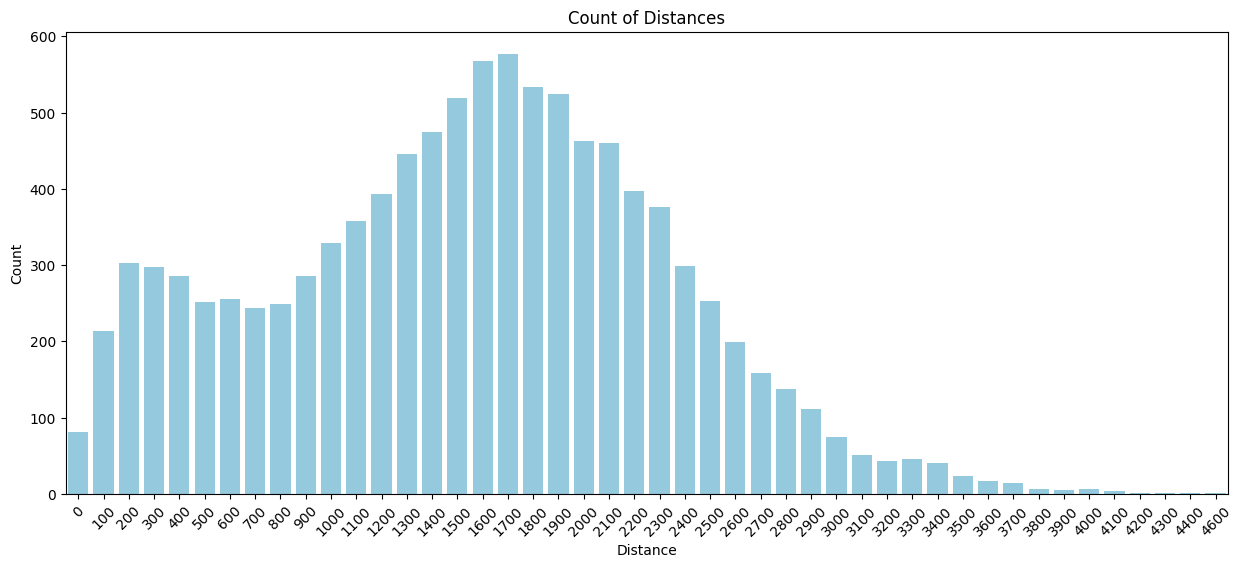

In [61]:
plt.figure(figsize=(15, 6))
sns.barplot(data=distance_counts, x='distance', y='count', color='skyblue')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Count of Distances')
plt.xticks(rotation=45)
plt.show()

In [62]:
players_role_distances_df = players_distances_df.merge(players_df, on='playerId', how='left').drop(columns={'shortName', 'currentNationalTeamId', 'currentTeamId'})
players_role_distances_df

,playerId,distance,role
0,36,2600.0,DF
1,36,2600.0,DF
2,36,2800.0,DF
3,36,1900.0,DF
4,36,2900.0,DF
...,...,...,...
10371,486252,2100.0,DF
10372,486252,1100.0,DF
10373,486252,1700.0,DF
10374,486252,2000.0,DF


In [63]:
# Count the occurrences of each unique distance value
distance_counts_by_role = players_role_distances_df[['distance', 'role']].value_counts().reset_index()

# Sort the DataFrame by distance
distance_counts_by_role = distance_counts_by_role.sort_values(by='distance')

distance_counts_by_role['distance'] = distance_counts_by_role['distance'].astype(int)

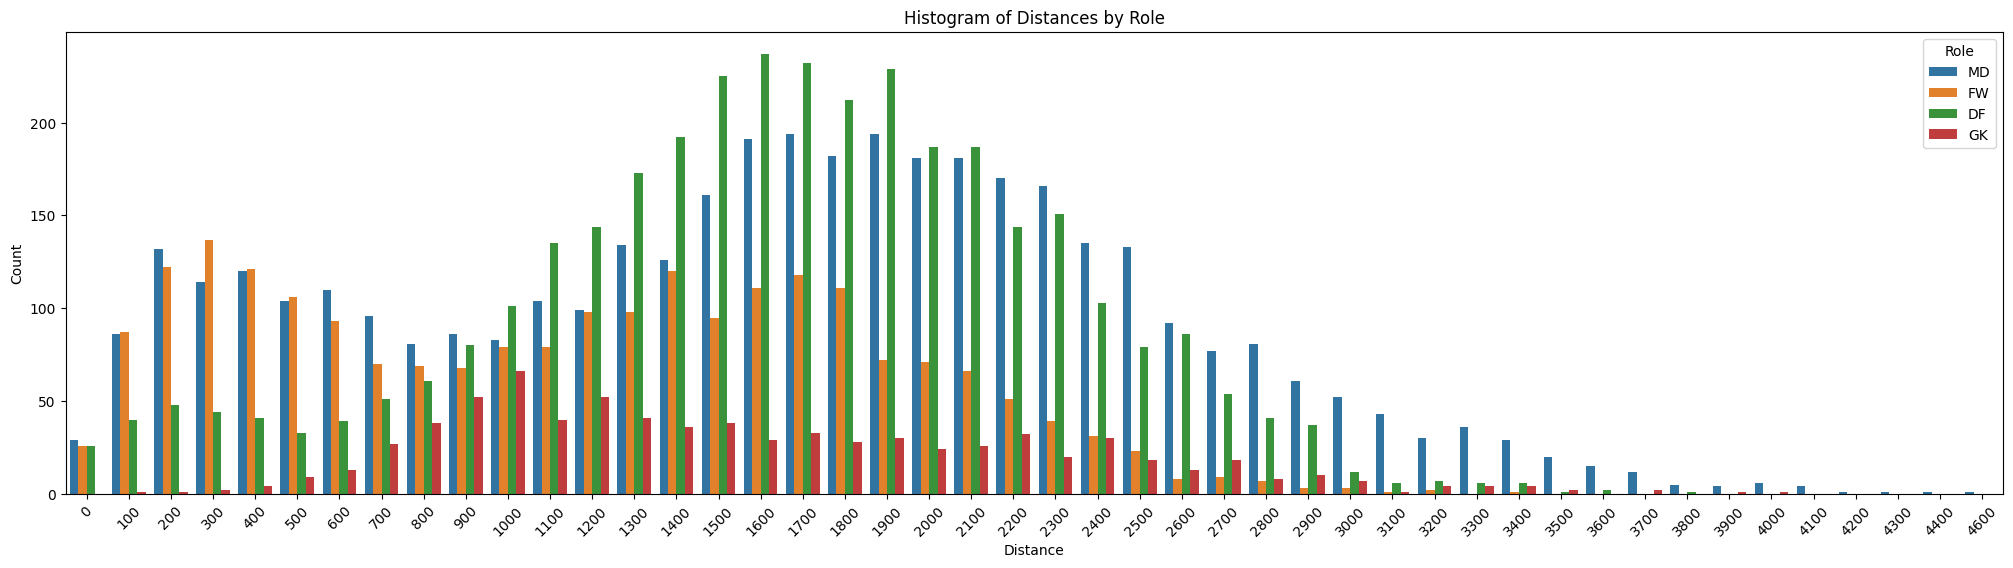

In [64]:
plt.figure(figsize=(25, 6))
sns.barplot(data=distance_counts_by_role, x='distance', y='count', hue='role')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Histogram of Distances by Role')
plt.legend(title='Role')
plt.xticks(rotation=45)
plt.show()

## Spanish first division analysis

In [65]:
spanish_teams_df = teams_df[(teams_df['area'] == 'Spain') & (teams_df['type'] == 'club')]

Removing the events that cause the game interruption

In [66]:
spanish_events_df = events_df['Spain'][events_df['Spain']['playerId'] != 0]

In [67]:
spanish_matches_df = matches_df['Spain']

I only need the first component of a pass, cross... So I can remove the second component

In [68]:
spanish_events_df['positions'] = spanish_events_df['positions'].apply(lambda x: x[0] if x else None)

Furthermore, I am decomposing the position in two columns: 'x' and 'y'

In [69]:
spanish_events_df['x'] = spanish_events_df['positions'].apply(lambda x: x.get('x'))
spanish_events_df['y'] = spanish_events_df['positions'].apply(lambda x: x.get('y'))
spanish_events_df.drop(columns={'positions'},inplace=True)

I am also going to change the name of the columns wyId in both players_df and italian_matches_df, in order to make a join among italian_events_df and the other two DataFrames just mentioned

In [70]:
spanish_matches_df.rename(columns={'wyId':'matchId'}, inplace=True)

Now I merge the three DataFrames

In [71]:
events_players_matches_join_df = pd.merge(spanish_events_df, players_df, on='playerId', how='left')

In [72]:
events_players_matches_join_df = pd.merge(events_players_matches_join_df, spanish_matches_df, on='matchId', how='left')

In [73]:
events_players_matches_join_df.drop(columns={'status','competitionId','seasonId','date','referees','duration',
                                             'venue', 'dateutc', 'shortName', 'roundId', 'teamsData', 'label',
                                             'currentTeamId', 'currentNationalTeamId'},inplace=True)

In [74]:
events_players_matches_join_df.head()

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,role,gameweek,winner
0,8,Simple pass,[{'id': 1801}],3542,2565548,Pass,682,1H,2.994582,85,180864419,37,61,MD,1,695
1,8,Simple pass,[{'id': 1801}],274435,2565548,Pass,682,1H,3.137020,85,180864418,50,50,FW,1,695
2,8,Simple pass,[{'id': 1801}],364860,2565548,Pass,682,1H,6.709668,85,180864420,45,30,MD,1,695
3,8,Simple pass,[{'id': 1801}],3534,2565548,Pass,682,1H,8.805497,85,180864421,38,12,DF,1,695
4,8,Simple pass,[{'id': 1801}],3695,2565548,Pass,682,1H,14.047492,85,180864422,32,69,DF,1,695


Now we analyze the distance made by players during a match

In [75]:
# Sort the dataframe by playerId, matchId, matchPeriod, gameweek, and eventSec
events_players_matches_join_df.sort_values(by=['matchId', 'playerId', 'matchPeriod', 'eventSec'], inplace=True)

# Compute the distance between consecutive points
events_players_matches_join_df['distance'] = np.sqrt(((events_players_matches_join_df.groupby(['matchId', 'playerId', 'matchPeriod'])['x'].diff()**2) + (events_players_matches_join_df.groupby(['playerId', 'matchId', 'matchPeriod', 'gameweek'])['y'].diff()**2)))

# Fill NaN values with 0
events_players_matches_join_df['distance'].fillna(0, inplace=True)

In [76]:
spanish_events_df.shape

(581978, 13)

In [77]:
events_players_matches_join_df

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,role,gameweek,winner,distance
5,8,Simple pass,[{'id': 1801}],3277,2565548,Pass,682,1H,18.480831,85,180864423,31,37,DF,1,695,0.000000
8,8,Simple pass,[{'id': 1801}],3277,2565548,Pass,682,1H,30.844379,85,180864426,33,41,DF,1,695,4.472136
35,8,Simple pass,[{'id': 1801}],3277,2565548,Pass,682,1H,165.998085,85,180864445,32,23,DF,1,695,18.027756
39,8,Simple pass,[{'id': 1801}],3277,2565548,Pass,682,1H,178.664114,85,180864449,24,31,DF,1,695,11.313708
46,3,Free Kick,[{'id': 1801}],3277,2565548,Free Kick,682,1H,211.660160,31,180864453,30,23,DF,1,695,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581592,8,Simple pass,[{'id': 1801}],399676,2565927,Pass,682,2H,1497.138576,85,253302205,70,54,MD,38,0,25.000000
581608,7,Clearance,"[{'id': 1401}, {'id': 1802}]",399676,2565927,Others on the ball,682,2H,1575.779022,71,253302210,79,87,MD,38,0,34.205263
581662,8,Simple pass,"[{'id': 1901}, {'id': 1801}]",399676,2565927,Pass,682,2H,1766.290679,85,253302260,32,59,MD,38,0,54.708317
581668,3,Corner,[{'id': 1801}],399676,2565927,Free Kick,682,2H,1818.383132,30,253302277,100,98,MD,38,0,78.390050


In [78]:
players_distances = events_players_matches_join_df.groupby(['playerId', 'matchId'])['distance'].sum()

In [79]:
players_distances_filtered = players_distances[players_distances != 0]

In [80]:
players_distances_rounded = round(players_distances_filtered, -2)

In [81]:
players_distances_df = pd.DataFrame(players_distances_rounded)

In [82]:
players_distances_df.head()

distance
playerId matchId          
33       2565884    1200.0
99       2565569     800.0
         2565924     200.0
151      2565606     300.0
         2565637     200.0

In [83]:
# Count the occurrences of each unique distance value
distance_counts = players_distances_df['distance'].value_counts().reset_index()

# Sort the DataFrame by distance
distance_counts = distance_counts.sort_values(by='distance')

In [84]:
distance_counts['distance'] = distance_counts['distance'].astype(int)

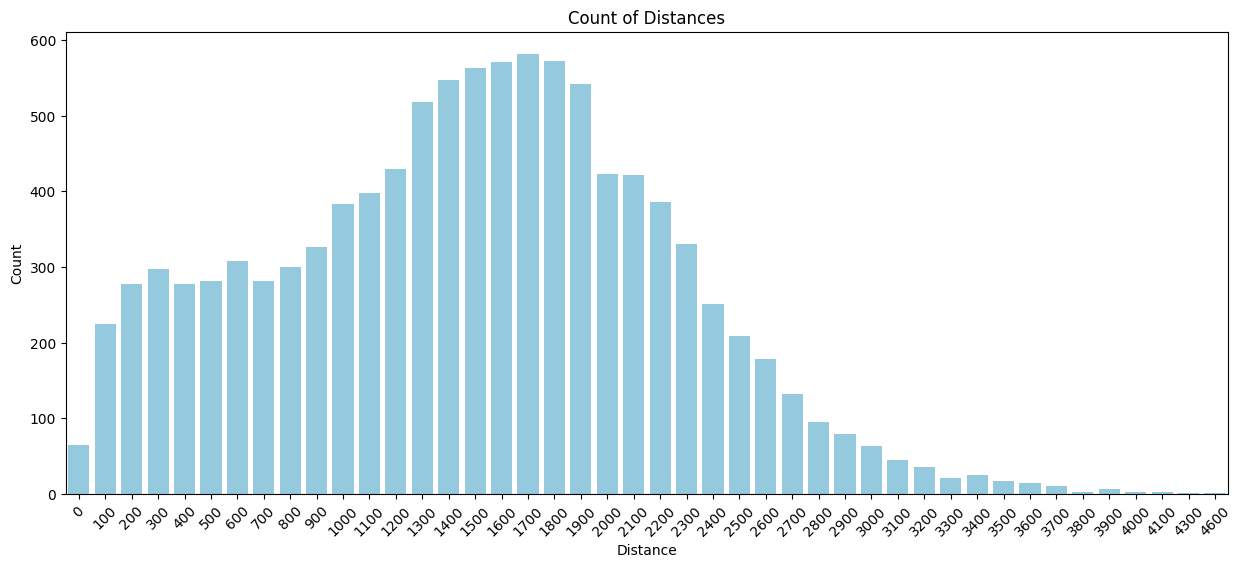

In [85]:
plt.figure(figsize=(15, 6))
sns.barplot(data=distance_counts, x='distance', y='count', color='skyblue')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Count of Distances')
plt.xticks(rotation=45)
plt.show()

In [86]:
players_role_distances_df = players_distances_df.merge(players_df, on='playerId', how='left').drop(columns={'shortName', 'currentNationalTeamId', 'currentTeamId'})
players_role_distances_df

,playerId,distance,role
0,33,1200.0,GK
1,99,800.0,GK
2,99,200.0,GK
3,151,300.0,FW
4,151,200.0,FW
...,...,...,...
10500,520163,1300.0,MD
10501,545811,200.0,FW
10502,545811,200.0,FW
10503,551398,600.0,DF


In [87]:
# Count the occurrences of each unique distance value
distance_counts_by_role = players_role_distances_df[['distance', 'role']].value_counts().reset_index()

# Sort the DataFrame by distance
distance_counts_by_role = distance_counts_by_role.sort_values(by='distance')

distance_counts_by_role['distance'] = distance_counts_by_role['distance'].astype(int)

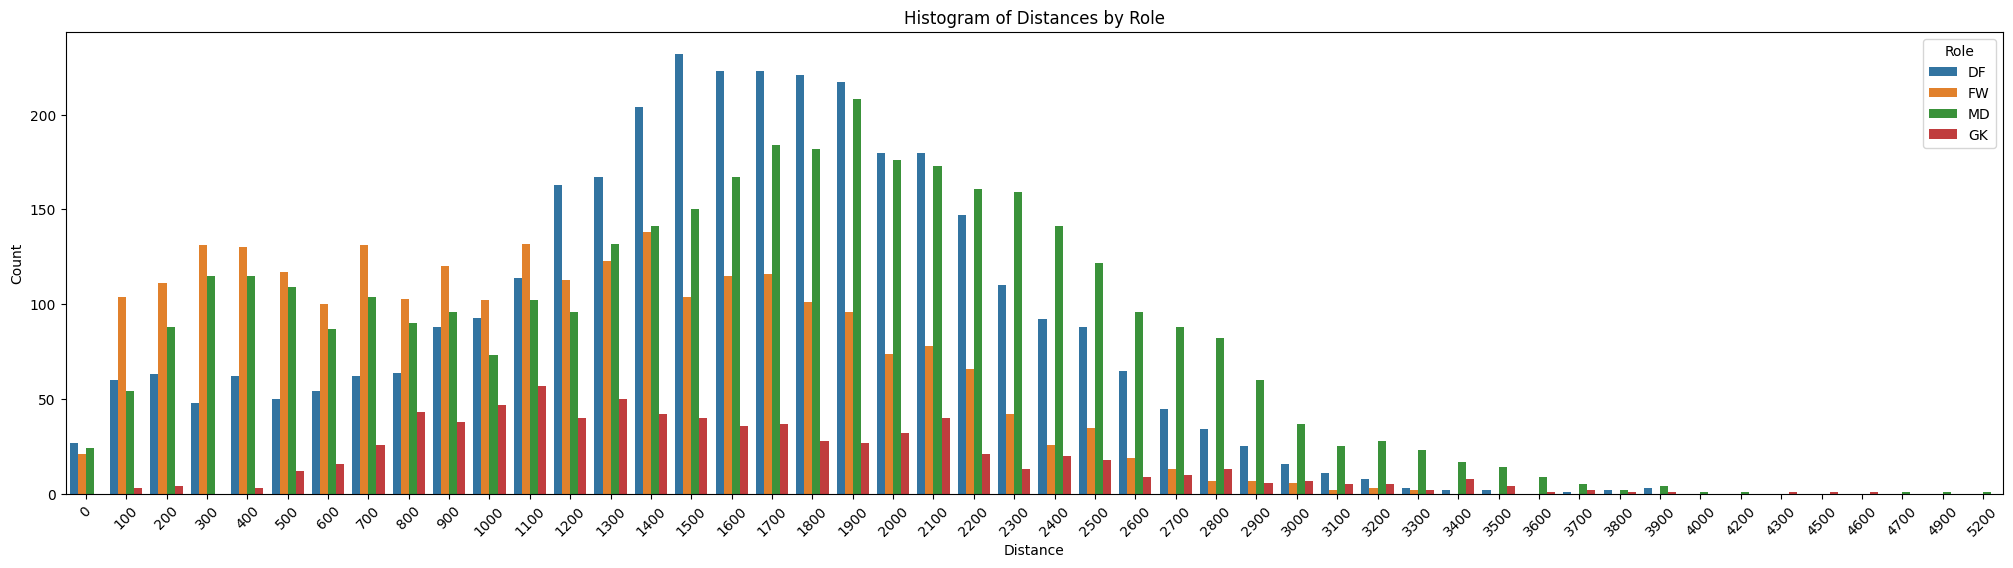

In [ ]:
plt.figure(figsize=(25, 6))
sns.barplot(data=distance_counts_by_role, x='distance', y='count', hue='role')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Histogram of Distances by Role')
plt.legend(title='Role')
plt.xticks(rotation=45)
plt.show()

## German first division analysis

In [88]:
german_teams_df = teams_df[(teams_df['area'] == 'Germany') & (teams_df['type'] == 'club')]

Removing the events that cause the game interruption

In [89]:
german_events_df = events_df['Germany'][events_df['Germany']['playerId'] != 0]

In [90]:
german_matches_df = matches_df['Germany']

I only need the first component of a pass, cross... So I can remove the second component

In [91]:
german_events_df['positions'] = german_events_df['positions'].apply(lambda x: x[0] if x else None)

Furthermore, I am decomposing the position in two columns: 'x' and 'y'

In [92]:
german_events_df['x'] = german_events_df['positions'].apply(lambda x: x.get('x'))
german_events_df['y'] = german_events_df['positions'].apply(lambda x: x.get('y'))
german_events_df.drop(columns={'positions'},inplace=True)

I am also going to change the name of the columns wyId in both players_df and italian_matches_df, in order to make a join among italian_events_df and the other two DataFrames just mentioned

In [93]:
german_matches_df.rename(columns={'wyId':'matchId'}, inplace=True)

Now I merge the three DataFrames

In [95]:
events_players_matches_join_df = pd.merge(german_events_df, players_df, on='playerId', how='left')

In [96]:
events_players_matches_join_df = pd.merge(events_players_matches_join_df, german_matches_df, on='matchId', how='left')

In [97]:
events_players_matches_join_df.drop(columns={'status','competitionId','seasonId','date','referees','duration',
                                             'venue', 'dateutc', 'shortName', 'roundId', 'teamsData', 'label',
                                             'currentTeamId', 'currentNationalTeamId'},inplace=True)

In [98]:
events_players_matches_join_df.head()

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,role,gameweek,winner
0,8,Simple pass,[{'id': 1801}],15231,2516739,Pass,2446,1H,2.409746,85,179896442,50,50,FW,1,2444
1,8,Simple pass,[{'id': 1801}],14786,2516739,Pass,2446,1H,2.506082,85,179896443,50,48,MD,1,2444
2,8,Simple pass,[{'id': 1801}],14803,2516739,Pass,2446,1H,6.946706,85,179896444,22,22,DF,1,2444
3,8,Simple pass,[{'id': 1801}],14768,2516739,Pass,2446,1H,10.786491,85,179896445,6,46,GK,1,2444
4,8,Simple pass,[{'id': 1801}],14803,2516739,Pass,2446,1H,12.684514,85,179896446,20,10,DF,1,2444


Now we analyze the distance made by players during a match

In [99]:
# Sort the dataframe by playerId, matchId, matchPeriod, gameweek, and eventSec
events_players_matches_join_df.sort_values(by=['matchId', 'playerId', 'matchPeriod', 'eventSec'], inplace=True)

# Compute the distance between consecutive points
events_players_matches_join_df['distance'] = np.sqrt(((events_players_matches_join_df.groupby(['matchId', 'playerId', 'matchPeriod'])['x'].diff()**2) + (events_players_matches_join_df.groupby(['playerId', 'matchId', 'matchPeriod', 'gameweek'])['y'].diff()**2)))

# Fill NaN values with 0
events_players_matches_join_df['distance'].fillna(0, inplace=True)

In [102]:
german_events_df.shape

(482163, 13)

In [103]:
events_players_matches_join_df

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,role,gameweek,winner,distance
1100,1,Air duel,"[{'id': 703}, {'id': 1801}]",14718,2516739,Duel,2444,2H,1242.519614,10,179897650,38,18,DF,1,2444,0.000000
1106,8,Simple pass,[{'id': 1801}],14718,2516739,Pass,2444,2H,1269.287350,85,179897660,36,10,DF,1,2444,8.246211
1124,8,Simple pass,[{'id': 1801}],14718,2516739,Pass,2444,2H,1451.949558,85,179897685,42,18,DF,1,2444,10.000000
1128,8,Simple pass,[{'id': 1801}],14718,2516739,Pass,2444,2H,1461.304660,85,179897693,56,7,DF,1,2444,17.804494
1165,8,Simple pass,[{'id': 1801}],14718,2516739,Pass,2444,2H,1541.243362,85,179897716,7,22,DF,1,2444,51.244512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482003,8,Simple pass,[{'id': 1802}],343685,2517044,Pass,2451,2H,2167.981416,85,251206613,9,94,DF,34,2451,27.073973
482011,7,Clearance,"[{'id': 1401}, {'id': 1802}]",343685,2517044,Others on the ball,2451,2H,2194.812304,71,251206619,7,53,DF,34,2451,41.048752
482105,7,Clearance,"[{'id': 1401}, {'id': 1802}]",343685,2517044,Others on the ball,2451,2H,2580.182798,71,251206720,6,58,DF,34,2451,5.099020
482129,8,Smart pass,"[{'id': 901}, {'id': 1802}]",343685,2517044,Pass,2451,2H,2687.919631,86,251206768,70,89,DF,34,2451,71.112587


In [104]:
players_distances = events_players_matches_join_df.groupby(['playerId', 'matchId'])['distance'].sum()

In [105]:
players_distances_filtered = players_distances[players_distances != 0]

In [106]:
players_distances_rounded = round(players_distances_filtered, -2)

In [107]:
players_distances_df = pd.DataFrame(players_distances_rounded)

In [108]:
players_distances_df.head()

distance
playerId matchId          
77       2516788    2100.0
         2516800    1000.0
         2516806    1500.0
         2516812    1800.0
         2516823    2100.0

In [109]:
# Count the occurrences of each unique distance value
distance_counts = players_distances_df['distance'].value_counts().reset_index()

# Sort the DataFrame by distance
distance_counts = distance_counts.sort_values(by='distance')

In [110]:
distance_counts['distance'] = distance_counts['distance'].astype(int)

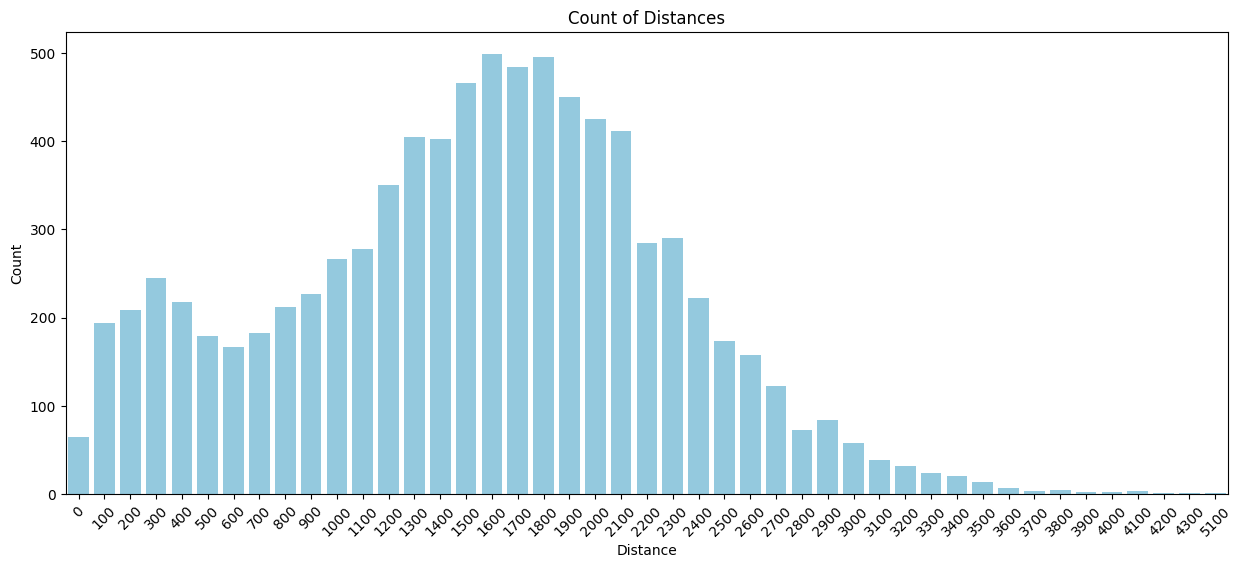

In [111]:
plt.figure(figsize=(15, 6))
sns.barplot(data=distance_counts, x='distance', y='count', color='skyblue')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Count of Distances')
plt.xticks(rotation=45)
plt.show()

In [112]:
players_role_distances_df = players_distances_df.merge(players_df, on='playerId', how='left').drop(columns={'shortName', 'currentNationalTeamId', 'currentTeamId'})
players_role_distances_df

,playerId,distance,role
0,77,2100.0,DF
1,77,1000.0,DF
2,77,1500.0,DF
3,77,1800.0,DF
4,77,2100.0,DF
...,...,...,...
8442,493725,300.0,DF
8443,503185,100.0,DF
8444,520617,1700.0,DF
8445,520617,400.0,DF


In [113]:
# Count the occurrences of each unique distance value
distance_counts_by_role = players_role_distances_df[['distance', 'role']].value_counts().reset_index()

# Sort the DataFrame by distance
distance_counts_by_role = distance_counts_by_role.sort_values(by='distance')

distance_counts_by_role['distance'] = distance_counts_by_role['distance'].astype(int)

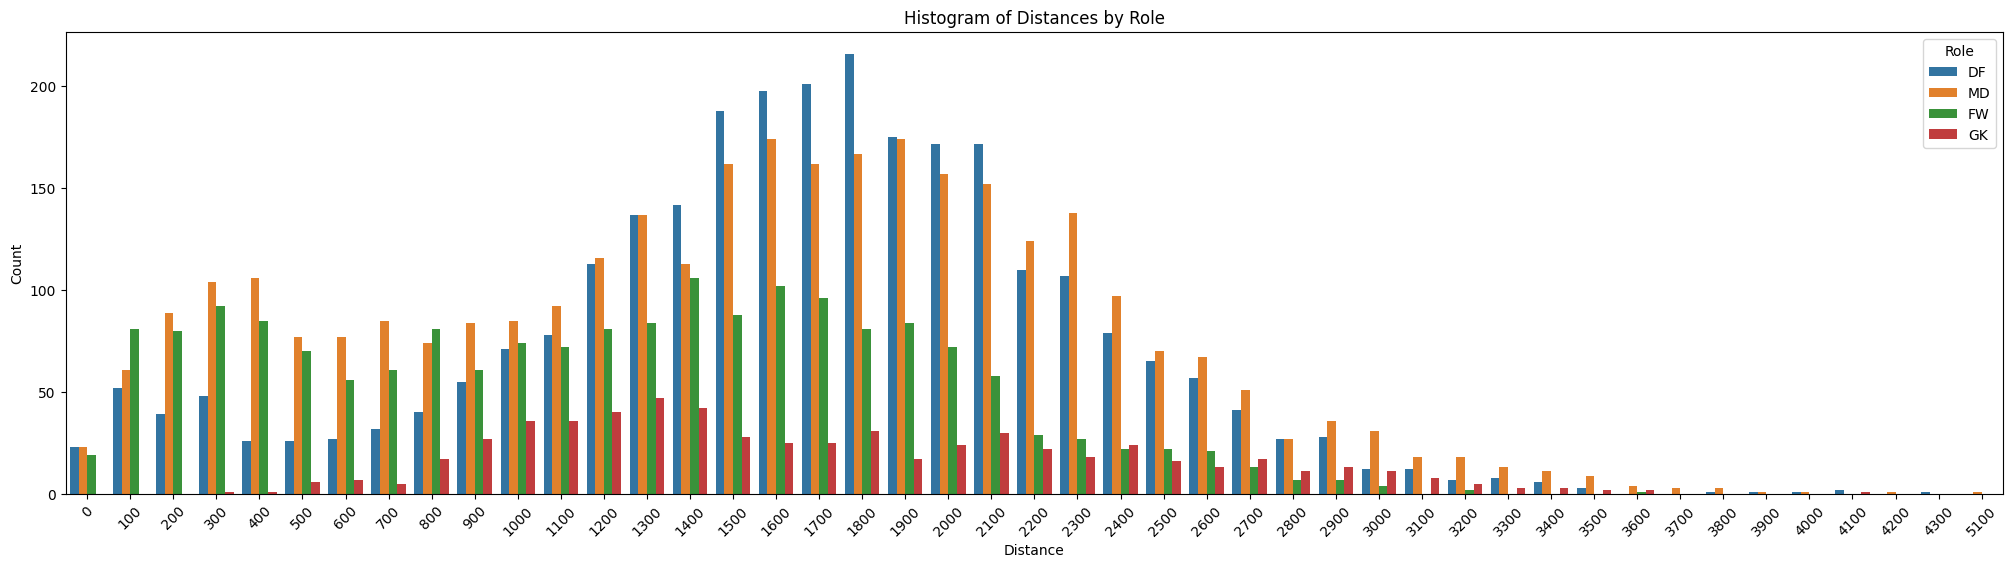

In [114]:
plt.figure(figsize=(25, 6))
sns.barplot(data=distance_counts_by_role, x='distance', y='count', hue='role')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Histogram of Distances by Role')
plt.legend(title='Role')
plt.xticks(rotation=45)
plt.show()

## French first division analysis

In [115]:
french_teams_df = teams_df[(teams_df['area'] == 'France') & (teams_df['type'] == 'club')]

Removing the events that cause the game interruption

In [116]:
french_events_df = events_df['France'][events_df['France']['playerId'] != 0]

In [117]:
french_matches_df = matches_df['France']

I only need the first component of a pass, cross... So I can remove the second component

In [118]:
french_events_df['positions'] = french_events_df['positions'].apply(lambda x: x[0] if x else None)

Furthermore, I am decomposing the position in two columns: 'x' and 'y'

In [119]:
french_events_df['x'] = french_events_df['positions'].apply(lambda x: x.get('x'))
french_events_df['y'] = french_events_df['positions'].apply(lambda x: x.get('y'))
french_events_df.drop(columns={'positions'},inplace=True)

I am also going to change the name of the columns wyId in both players_df and italian_matches_df, in order to make a join among italian_events_df and the other two DataFrames just mentioned

In [120]:
french_matches_df.rename(columns={'wyId':'matchId'}, inplace=True)

Now I merge the three DataFrames

In [121]:
events_players_matches_join_df = pd.merge(french_events_df, players_df, on='playerId', how='left')

In [122]:
events_players_matches_join_df = pd.merge(events_players_matches_join_df, french_matches_df, on='matchId', how='left')

In [123]:
events_players_matches_join_df.drop(columns={'status','competitionId','seasonId','date','referees','duration',
                                             'venue', 'dateutc', 'shortName', 'roundId', 'teamsData', 'label',
                                             'currentTeamId', 'currentNationalTeamId'},inplace=True)

In [124]:
events_players_matches_join_df.head()

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,role,gameweek,winner
0,8,Simple pass,[{'id': 1801}],253784,2500686,Pass,3799,1H,1.935181,85,176505119,50,51,FW,1,0
1,8,High pass,[{'id': 1801}],29474,2500686,Pass,3799,1H,3.599295,83,176505121,31,46,DF,1,0
2,1,Air duel,"[{'id': 703}, {'id': 1801}]",253784,2500686,Duel,3799,1H,6.827043,10,176505122,68,74,FW,1,0
3,1,Air duel,"[{'id': 701}, {'id': 1802}]",56441,2500686,Duel,3772,1H,6.985577,10,176505017,32,26,MD,1,0
4,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",366760,2500686,Duel,3799,1H,9.511272,11,176505124,72,54,MD,1,0


Now we analyze the distance made by players during a match

In [125]:
# Sort the dataframe by playerId, matchId, matchPeriod, gameweek, and eventSec
events_players_matches_join_df.sort_values(by=['matchId', 'playerId', 'matchPeriod', 'eventSec'], inplace=True)

# Compute the distance between consecutive points
events_players_matches_join_df['distance'] = np.sqrt(((events_players_matches_join_df.groupby(['matchId', 'playerId', 'matchPeriod'])['x'].diff()**2) + (events_players_matches_join_df.groupby(['playerId', 'matchId', 'matchPeriod', 'gameweek'])['y'].diff()**2)))

# Fill NaN values with 0
events_players_matches_join_df['distance'].fillna(0, inplace=True)

In [126]:
italian_events_df.shape

(600585, 13)

In [127]:
events_players_matches_join_df

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,role,gameweek,winner,distance
27,8,Simple pass,[{'id': 1801}],3573,2500686,Pass,3772,1H,53.675121,85,176505028,29,47,MD,1,0,0.000000
30,8,Head pass,[{'id': 1801}],3573,2500686,Pass,3772,1H,61.865448,82,176505030,30,79,MD,1,0,32.015621
38,8,Simple pass,[{'id': 1801}],3573,2500686,Pass,3772,1H,94.604230,85,176505037,33,74,MD,1,0,5.830952
40,8,Simple pass,[{'id': 1801}],3573,2500686,Pass,3772,1H,100.091015,85,176505039,31,58,MD,1,0,16.124515
46,8,Simple pass,[{'id': 1801}],3573,2500686,Pass,3772,1H,121.364049,85,176505045,29,67,MD,1,0,9.219544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585401,1,Ground attacking duel,"[{'id': 503}, {'id': 701}, {'id': 1802}]",472126,2501065,Duel,19830,2H,2355.421336,11,253316867,46,4,DF,38,19830,40.496913
585415,1,Ground defending duel,"[{'id': 501}, {'id': 701}, {'id': 1802}]",472126,2501065,Duel,19830,2H,2409.980066,12,253316877,3,28,DF,38,19830,49.244289
585421,1,Air duel,"[{'id': 701}, {'id': 1802}]",472126,2501065,Duel,19830,2H,2493.375090,10,253316881,38,27,DF,38,19830,35.014283
585457,1,Air duel,"[{'id': 703}, {'id': 1801}]",472126,2501065,Duel,19830,2H,2624.797701,10,253316919,13,33,DF,38,19830,25.709920


In [128]:
players_distances = events_players_matches_join_df.groupby(['playerId', 'matchId'])['distance'].sum()

In [129]:
players_distances_filtered = players_distances[players_distances != 0]

In [130]:
players_distances_rounded = round(players_distances_filtered, -2)

In [131]:
players_distances_df = pd.DataFrame(players_distances_rounded)

In [132]:
players_distances_df.head()

distance
playerId matchId          
66       2501047     300.0
         2501061     200.0
102      2500688    1900.0
         2500703    1500.0
         2500707    1100.0

In [133]:
# Count the occurrences of each unique distance value
distance_counts = players_distances_df['distance'].value_counts().reset_index()

# Sort the DataFrame by distance
distance_counts = distance_counts.sort_values(by='distance')

In [134]:
distance_counts['distance'] = distance_counts['distance'].astype(int)

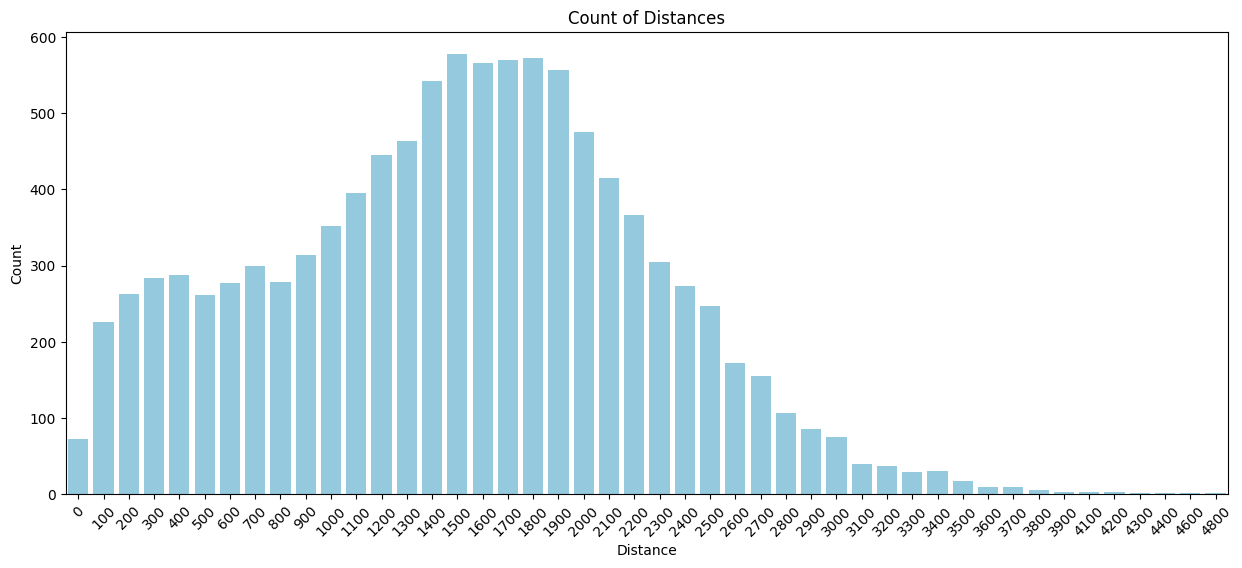

In [135]:
plt.figure(figsize=(15, 6))
sns.barplot(data=distance_counts, x='distance', y='count', color='skyblue')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Count of Distances')
plt.xticks(rotation=45)
plt.show()

In [136]:
players_role_distances_df = players_distances_df.merge(players_df, on='playerId', how='left').drop(columns={'shortName', 'currentNationalTeamId', 'currentTeamId'})
players_role_distances_df

,playerId,distance,role
0,66,300.0,FW
1,66,200.0,FW
2,102,1900.0,DF
3,102,1500.0,DF
4,102,1100.0,DF
...,...,...,...
10457,521939,300.0,FW
10458,566942,100.0,MD
10459,566942,800.0,MD
10460,566942,400.0,MD


In [137]:
# Count the occurrences of each unique distance value
distance_counts_by_role = players_role_distances_df[['distance', 'role']].value_counts().reset_index()

# Sort the DataFrame by distance
distance_counts_by_role = distance_counts_by_role.sort_values(by='distance')

distance_counts_by_role['distance'] = distance_counts_by_role['distance'].astype(int)

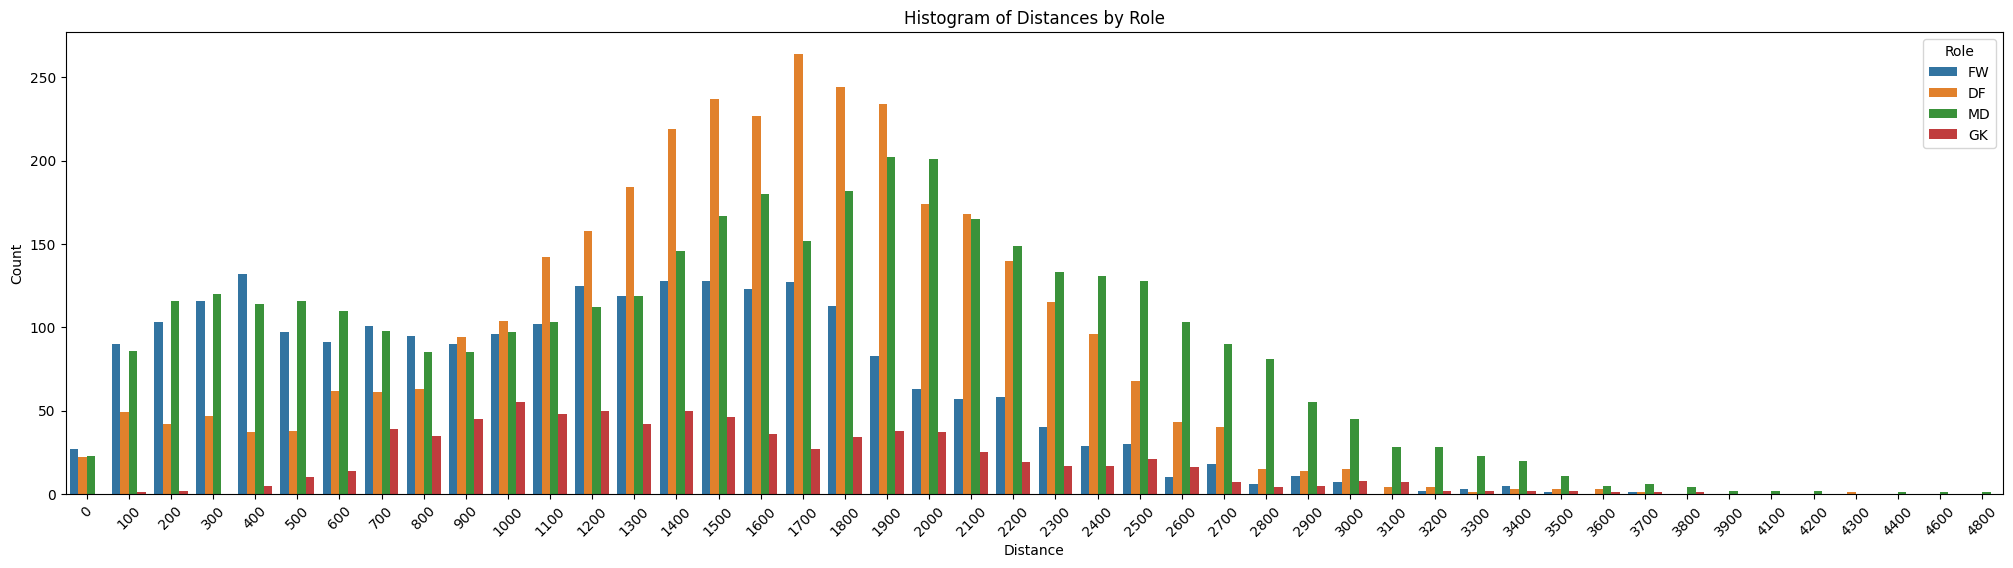

In [138]:
plt.figure(figsize=(25, 6))
sns.barplot(data=distance_counts_by_role, x='distance', y='count', hue='role')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Histogram of Distances by Role')
plt.legend(title='Role')
plt.xticks(rotation=45)
plt.show()

## European Championship

In [142]:
competitions_df

,name,wyId,format,area,type
0,Italian first division,524,Domestic league,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club
1,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,Spanish first division,795,Domestic league,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,French first division,412,Domestic league,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
4,German first division,426,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
5,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international
6,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international


In [140]:
national_teams_df = teams_df[teams_df['type'] == 'national']

In [146]:
european_events_df = events_df['European_Championship'][events_df['European_Championship']['playerId'] != 0]

In [147]:
european_events_df.shape

(78140, 12)

In [148]:
european_matches_df = matches_df['European_Championship']

In [154]:
european_matches_df['groupName'].unique()

array(['Group F', 'Group E', 'Group D', 'Group C', 'Group B', 'Group A'],
      dtype=object)

## World Cup